## Multiunit recordings from several cortical areas

We will collect neurons from several cortical areas to perform population *dynamical* and *attractor* analysis, and get the *functional connectivity*.     
This will address three relevant points:
- Does the dynamic analysis hold at **higher temporal resolution**?
    - How do events statistics (duration and size) compare to 2-photon?
- Are population events only a **side-effect of behavior** (locomotion, whisker pad, pupil)?
    - Do behavioral components explain pattern reproducibility?
- Do **all areas of cortex** show attractor dynamics?
    - How do pattern trajectories compare to MICrONS?

To do all this, we analyse the [data](https://janelia.figshare.com/articles/dataset/Eight-probe_Neuropixels_recordings_during_spontaneous_behaviors/7739750/4) by [Stringer et al. 2019](science.org/doi/10.1126/science.aav7893).   
Eight-probe Neuropixels recordings in three mice during spontaneous activity.   

This notebook calls `dynamical_analysis.ipynb` and `attractor_analysis.ipynb`.

In [1]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


**WARNING**: the next cell takes time to download and unzip the neuropixel data.

In [2]:
if not os.path.exists("stringer/7739750.zip"):
    print("Downloading neuropixel data ...")
    if not os.path.exists("stringer"):
        os.makedirs("stringer")
    resp = wget.download("https://janelia.figshare.com/ndownloader/articles/7739750/versions/4", "stringer/7739750.zip")
    print("... Done: "+resp)

if not os.path.exists("stringer/7739750"):
    # unzip downloaded folder
    if os.path.exists("stringer/7739750.zip"):
        print("... unzipping")
        shutil.unpack_archive("stringer/7739750.zip", "stringer/7739750")
        shutil.unpack_archive("stringer/7739750/spks.zip", "stringer/7739750/spks")
        shutil.unpack_archive("stringer/7739750/faces.zip", "stringer/7739750/faces")
    print("Done.")
else:
    print("All data available.")

All data available.


### Data preprocessing

This analysis is based on the file `ephysLoad.m`.

Each "spks" is a structure of length 8, where each entry is a different probe (these probes were recorded simultaneously). It contains the spike times (in seconds, e.g. 4048.44929626 sec (?kHz sampling)), the cluster identity of each spike (its cell), and the height of each cluster on the probe.

The location of each site on the probe in microns in the Allen CCF framework is given in "ccfCoords". The brain area for each site is in "borders" as a function of the height of the site. 

We need the spikes from each area and probe to be separate lists. So, we build a dictionary to hold them, and save it locally as `area_spiketrains.npy`.

In [3]:
if os.path.exists("stringer/7739750/area_spiketrains.npy"):
    area_spiketrains = np.load("stringer/7739750/area_spiketrains.npy", allow_pickle=True).item()
    print("... loaded populations")
else:
    print("... collecting populations")
    
    probeLoc = sio.loadmat('stringer/7739750/probeLocations.mat')
    probeBorders = sio.loadmat('stringer/7739750/probeBorders.mat', squeeze_me=True)

    mouse_names = ['Krebs','Waksman','Robbins']
    cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']

    # first count the cells you want to take with this structure
    # then think on how you want to store the spikes... compatible with the dynamical_analysis
    area_spiketrains = {
        'Krebs' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Waksman' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Robbins' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]}
    }

    for imouse in range(len(mouse_names)):
        print(mouse_names[imouse])

        spks = sio.loadmat('stringer/7739750/spks/spks%s_Feb18.mat'%mouse_names[imouse], squeeze_me=True)

        # probe k
        # k = 7
        for k in range(8):
            print("probe",k)

            # spike times (in seconds)
            st = spks['spks'][k][0]
            # clusters
            clu = spks['spks'][k][1]
            print("clusters (cells) of the spikes",len(np.unique(clu)))
            # cluster heights (in microns)
            # (see siteCoords to convert to site location)
            Wh = spks['spks'][k][2]

            # where is the probe in the brain (consolidated labels)
            # borders are in microns
            # use Wh to determine which clusters are in which brain region
            borders = probeBorders['probeBorders'][imouse]['borders'][k]
            for j in range(len(borders)):
                population = [] # one population per border, there can be several borders
                b = borders[j]
                if b[2] not in cortical_areas:
                    continue
                print('upper border %d um, lower border %d um, area %s'%(b[0],b[1],b[2]))
                wneurons = np.logical_and(Wh>=b[1], Wh<b[0])
                nn = wneurons.sum()
                print('%d neurons in %s'%(nn,b[-1]))
                # we should not include population smaller than those in MICrONS
                if nn<10:
                    print('population too small. Rejected.')
                    continue

                cortical_neurons = np.nonzero(wneurons)[0]
                for cn in cortical_neurons:
                    cn_idxs = [i for i in range(len(clu)) if clu[i]==cn]
                    # print(cn_idxs)
                    population.append( sorted(st[cn_idxs]) )
                    
                area_spiketrains[ mouse_names[imouse] ][ b[2] ].append( population )
            print()

    # save to file
    np.save("stringer/7739750/area_spiketrains.npy", area_spiketrains)


... loaded populations


The following spiketrains will be loaded.

| mouse | probe | borders (um) | area | #neurons |
|:----|:----|:----|:---|:---|
| **Krebs** | 0 | 4000, 1100 | FrMoCtx | 5 |
|           | 1 | 4000, 1800 | FrMoCtx | 73 |
|           | 2 | 4000, 2600 | V1 | 61 |
|           | 3 | 4000, 2400 | V1 | 141 |
|           | 4 | 4000, 1800 | SomMoCtx | 65 |
|           | 5 | 4000, 2100 | SomMoCtx | 26 |
|           | 6 | 4000, 2350 | V1 | 68 |
|           | 7 | 4000, 2600 | V1 | 64 |
| **Waksman** | 0 | 4000, 1700 | FrMoCtx | 446 |
|             | 0 | 1200, 0 | FrMoCtx | 201 |
|             | 1 | 4000, 2150 | FrCtx | 31 |
|             | 2 | 4000, 2700 | V1 | 155 |
|             | 3 | 4000, 2250 | RSP | 112 |
|             | 4 | 4000, 2000 | SomMoCtx | 220 |
|             | 5 | 4000, 2600 | SSCtx | 50 |
|             | 6 | 4000, 2650 | V2 | 124 |
|             | 7 | 4000, 2850 | V1 | 96 |
| **Robbins** | 0 | 4000, 3400 | FrMoCtx | 16 |
|             | 1 | 4000, 3100 | FrMoCtx | 70 |
|             | 3 | 4000, 3550 | RSP | 10 |
|             | 4 | 4000, 3500 | SomMoCtx | 10 |


In [4]:
real_frame_duration = 0.00000001 # sec (e.g. 4048.44929626 s)
# frame_duration = 0.001 # ms (e.g. 4048.449 s)
frame_duration = 0.01 # 10ms (e.g. 4048.45 s)
local_path = os.getcwd() + '/stringer/7739750/'

#### Note
The cell below is particularly long to execute if the dynamical and attractor analyses are used. We therefore used only the first mouse 'Krebs' to perform those analyses.     
However, functional correlations and hirarchical modularity are light enough to be performed on all mice (with a good bit of patience). By commenting the sections on 


mouse: Krebs

mouse: Waksman
area:  FrCtx
population: 0
    time: 246629
    cells: 31
... Dynamical Analysis
    population firing: 1.43±1.43 sp/frame
    cells firing rate: 0.05±0.24 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.3156119246438798
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 13238
    number of events per sec: 2.1704129982129095
    events duration: 0.090±0.037
    events size: 7.000±2.531
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.3179983683883768
    cluster size threshold: 2
    Total number of clusters: 135
    # clusters (after removing those below reproducibility threshold): 134
    event color assignment
    unique color assignments
    clustered similarity map
    finding clu

/tmp/ipykernel_1810/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_1810/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=22, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting cores: DescribeResult(nobs=22, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges sourcing from others: DescribeResult(nobs=9, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=9, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  nan p= nan
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  nan p= nan
    Kolmogorov-Smirnov Effect Size: 0.000


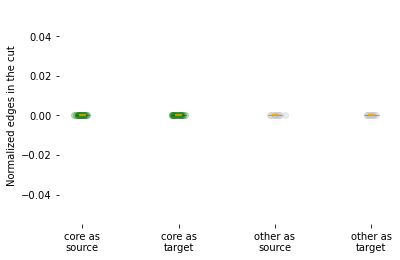

... PageRank centrality
    cores: DescribeResult(nobs=22, minmax=(0.0437636761487965, 0.08096280087527352), mean=0.045454545454545456, variance=6.289885820072699e-05, skewness=4.364357804719853, kurtosis=17.04761904761906)
    others: DescribeResult(nobs=9, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  27.900 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


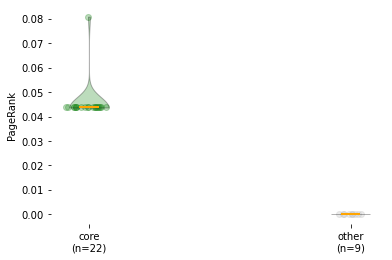

area:  FrMoCtx
population: 0
    time: 247994
    cells: 446
... Dynamical Analysis
    population firing: 10.73±4.95 sp/frame
    cells firing rate: 0.02±0.16 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 16.28404545813285
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 6292
    number of events per sec: 1.0299574888811407
    events duration: 0.100±0.044
    events size: 69.000±29.666
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 1160
    # clusters (after removing those below reproducibility threshold): 1139
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing un

/tmp/ipykernel_1810/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_1810/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
... PageRank centrality
population: 1
area:  SomMoCtx
population: 0
    time: 248545
    cells: 220
... Dynamical Analysis
    population firing: 9.11±5.83 sp/frame
    cells firing rate: 0.04±0.22 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 11.724195413968474
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 15235
    number of events per sec: 2.492625199810865
    events duration: 0.100±0.044
    events size: 44.000±17.171
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 549
    # clusters (after removing those below reproducibility threshold): 546
    event color assignment
    unique color assignments
    clustered similarity map

/tmp/ipykernel_1810/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_1810/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=218, minmax=(0.0, 7.426605504587156), mean=0.03406699772746402, variance=0.2530021528475424, skewness=14.663035439326022, kurtosis=213.00460829493093)
    Cut edges targeting cores: DescribeResult(nobs=218, minmax=(0.0, 7.426605504587156), mean=0.03406699772746402, variance=0.25300215284754246, skewness=14.663035439326036, kurtosis=213.00460829493085)
    Cut edges sourcing from others: DescribeResult(nobs=2, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=2, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.000 p= 0.318
    Kolmogorov-Smirnov Effect Size: 0.005


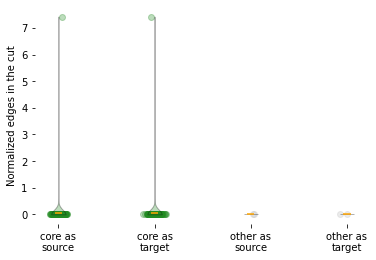

... PageRank centrality
    cores: DescribeResult(nobs=218, minmax=(0.004360465116280265, 0.02906976744174257), mean=0.004587155963302753, variance=5.575559896194073e-06, skewness=10.296079800548322, kurtosis=104.00925925925921)
    others: DescribeResult(nobs=2, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  110.503 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


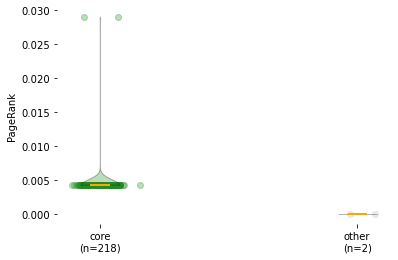

area:  SSCtx
population: 0
    time: 247713
    cells: 50
... Dynamical Analysis
    population firing: 3.01±2.90 sp/frame
    cells firing rate: 0.06±0.26 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.67520916602476
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 11336
    number of events per sec: 1.8561332957827656
    events duration: 0.100±0.042
    events size: 14.000±6.218
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.21953825673565244
    cluster size threshold: 2
    Total number of clusters: 156
    # clusters (after removing those below reproducibility threshold): 156
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores 

/tmp/ipykernel_1810/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_1810/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=36, minmax=(0.0, 89.86111111111111), mean=2.496141975308642, variance=224.30609139231828, skewness=5.74704893215391, kurtosis=31.02857142857144)
    Cut edges targeting cores: DescribeResult(nobs=36, minmax=(0.0, 89.86111111111111), mean=2.496141975308642, variance=224.30609139231828, skewness=5.74704893215391, kurtosis=31.02857142857144)
    Cut edges sourcing from others: DescribeResult(nobs=14, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=14, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.000 p= 0.324
    Kolmogorov-Smirnov Effect Size: 0.028


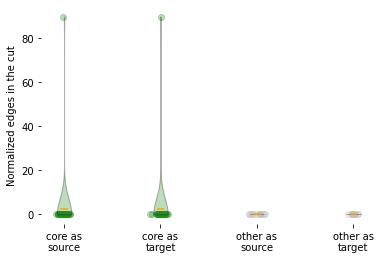

... PageRank centrality
    cores: DescribeResult(nobs=36, minmax=(0.021126760563380285, 0.1408450704225352), mean=0.027777777777777776, variance=0.0007734985814731893, skewness=3.880570000581329, kurtosis=13.058823529411782)
    others: DescribeResult(nobs=14, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  44.661 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


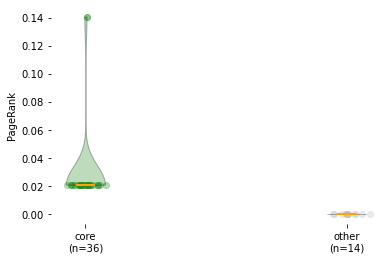

area:  V1
population: 0
    time: 246589
    cells: 155
... Dynamical Analysis
    population firing: 8.40±6.73 sp/frame
    cells firing rate: 0.05±0.25 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 10.694989974004564
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 17801
    number of events per sec: 2.917488871552476
    events duration: 0.100±0.044
    events size: 39.000±16.418
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 275
    # clusters (after removing those below reproducibility threshold): 275
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecifi

/tmp/ipykernel_1810/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=103, minmax=(0.0, 107.03883495145631), mean=1.2034121971910643, variance=113.66847308452633, skewness=9.667297441963726, kurtosis=93.1817134373338)
    Cut edges targeting cores: DescribeResult(nobs=103, minmax=(0.0, 107.03883495145631), mean=1.2034121971910643, variance=113.66847308452633, skewness=9.667297441963726, kurtosis=93.1817134373338)
    Cut edges sourcing from others: DescribeResult(nobs=52, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=52, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.146 p= 0.255
    Kolmogorov-Smirnov Effect Size: 0.019


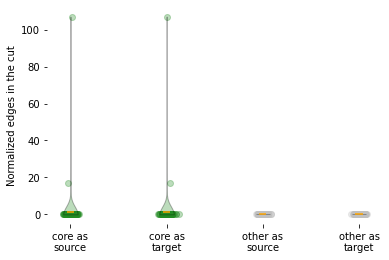

... PageRank centrality
    cores: DescribeResult(nobs=103, minmax=(0.007957559681703457, 0.10179941214395932), mean=0.009708737864077669, variance=0.00010770799710295239, skewness=7.4043252440144345, kurtosis=59.75669805599252)
    others: DescribeResult(nobs=52, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  146.785 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


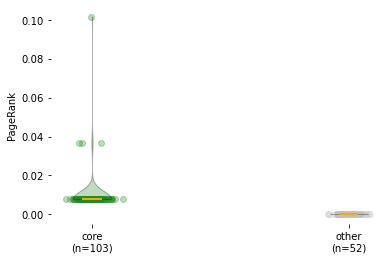

population: 1
    time: 244404
    cells: 96
... Dynamical Analysis
    population firing: 5.45±5.80 sp/frame
    cells firing rate: 0.06±0.27 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 6.780072045325212
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 14466
    number of events per sec: 2.3740167753349075
    events duration: 0.110±0.048
    events size: 22.000±13.144
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.1591759317292575
    cluster size threshold: 2
    Total number of clusters: 86
    # clusters (after removing those below reproducibility threshold): 86
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspeci

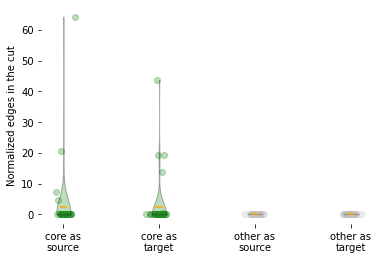

... PageRank centrality
    cores: DescribeResult(nobs=42, minmax=(0.014218009478672989, 0.12384820022658184), mean=0.023809523809523808, variance=0.0007601407613394096, skewness=2.71766095710031, kurtosis=5.991079573703637)
    others: DescribeResult(nobs=54, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  91.710 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


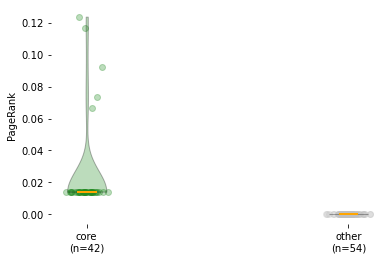

area:  V2
population: 0
    time: 245631
    cells: 124
... Dynamical Analysis
    population firing: 7.21±5.21 sp/frame
    cells firing rate: 0.06±0.27 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 9.866594351771742
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 14614
    number of events per sec: 2.396672800207294
    events duration: 0.100±0.047
    events size: 33.000±12.528
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.1379847735236924
    cluster size threshold: 2
    Total number of clusters: 215
    # clusters (after removing those below reproducibility threshold): 213
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores fi

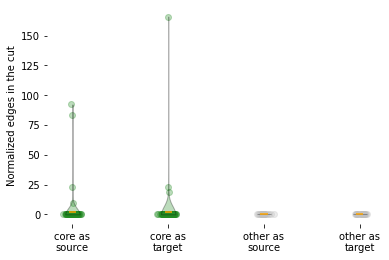

... PageRank centrality
    cores: DescribeResult(nobs=96, minmax=(0.008426966292134831, 0.07544845259215455), mean=0.010416666666666663, variance=0.00012419530008319442, skewness=5.400670028206409, kurtosis=27.21663561798436)
    others: DescribeResult(nobs=28, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  113.849 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


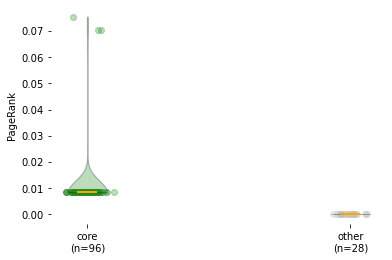

area:  RSP
population: 0
    time: 246567
    cells: 112
... Dynamical Analysis
    population firing: 9.86±7.63 sp/frame
    cells firing rate: 0.09±0.31 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 11.713855869650864
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 20150
    number of events per sec: 3.300940972950304
    events duration: 0.100±0.044
    events size: 50.000±18.287
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.13759007693534073
    cluster size threshold: 2
    Total number of clusters: 183
    # clusters (after removing those below reproducibility threshold): 183
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores

In [ ]:
# start of spontaneous activity in each mouse (in seconds)
etstart = [3811, 3633, 3323]

all_degrees = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_local_clustering_coefficients = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_core_local_clustering_coefficients = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_pagerank_cores = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_pagerank_others = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }

for imouse,(mousename,areas) in enumerate(area_spiketrains.items()):
    print("\nmouse:",mousename)
    
    # # to reduce computations, use comments here
    # if mousename not in ["Krebs", "Waksman"]:
    # if mousename not in ["Waksman","Robbins"]:
    # if mousename not in ["Robbins"]:
    if mousename not in ["Waksman"]:
        continue
        
    exp_path = local_path + '%s/'%mousename
    exp_tstart = etstart[imouse]

    # reading behavior data to make statistics about event dependence on it
    # we will use the field 'stimulus' to store the avg motSVD of the frames 
    # The behavioral file is the processed version of a mouse face movie (time x pixels x pixels). 
    faces = sio.loadmat('stringer/7739750/faces/%s_face_proc.mat'%mousename, squeeze_me=True)
    video_timestamps = faces['times'] # same temporal resolution of ephy
    motSVD = faces['motionSVD']
    exp_istart = (np.abs(video_timestamps - exp_tstart)).argmin()    
    motSVD_1c = motSVD[:,0] # only first component
    motSVD_1c[motSVD_1c < -4000] = np.mean(motSVD_1c) # corrections
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(video_timestamps[exp_istart:], motSVD_1c[exp_istart:], linewidth=0.5, color='k')
    fig.savefig(exp_path+"/motSVD_%s.png"%mousename, transparent=True, dpi=900)
    plt.close()
    fig.clear()
    fig.clf()

    for area,probe_populations in areas.items():
        if len(probe_populations)>0:
            print("area: ",area)
            
            # # to reduce computations, use comments here
            # if area not in ['FrCtx', 'FrMoCtx']:
            # if area not in ['V1']:
            #     continue
                                                
            for ipop,spiketrains in enumerate(probe_populations): 
                print("population:",ipop)

                if mousename=='Waksman' and area=='FrMoCtx' and ipop==1:
                    continue # no events

                # rounding to ms
                # spiketrains = [np.round(sp, 3) for sp in spiketrains] # ms
                spiketrains = [np.round(sp, 2) for sp in spiketrains] # 10ms
                start_time = min([min(st) if len(st) else 0 for st in spiketrains])
                stop_time = max([max(st) if len(st) else 0 for st in spiketrains])
                time = np.arange(start_time,stop_time,frame_duration)
                print("    time:", len(time))
                print("    cells:", len(spiketrains))

                fig = plt.figure(figsize=[12.8,4.8])
                for row,train in enumerate(spiketrains):
                    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
                plt.ylabel("cell IDs")
                plt.xlabel("time (s)")
                # plt.show()
                fig.savefig(exp_path+'%s_%s_rasterplot.png'%(area,ipop), transparent=False, dpi=800)
                plt.tight_layout()
                plt.close()
                
                ophys_cell_ids = list(range(len(spiketrains)))
                ophys_cell_indexes = ophys_cell_ids # here is an alias

                scan_spiketrains = spiketrains
                scan_id = '_%s_%s'%(area,ipop)
                
                # --------------------------------------------------------------------------
                print("... Dynamical Analysis")
                core_reproducibility_perc = 99 # threshold for detecting cores
                %run "dynamical_analysis.ipynb"
                
                # # Match smooth motion energy curve with the cluster it belongs to
                # # Count the number of events belonging to a pattern before and after the change.
                # ccolors,ccounts = np.unique(cluster_color_array, return_counts=True)
                # cluster_events_counts = dict(zip(ccolors,ccounts))
                # Npre_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # Npost_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # for sni in smoothed_beh_indices:
                #     snitime = exp_tstart + sni * frame_duration
                #     snitime_pre = snitime - 0.15 # s
                #     snitime_post = snitime + 0.15 # s
                #     for ievent,(event,ecolor) in enumerate(zip(events,cluster_color_array)):
                #         event_start_time = exp_tstart + event['start'] * frame_duration
                #         if snitime_pre < event_start_time and event_start_time < snitime:
                #             Npre_beh_cluster[ecolor] += 1
                #         if snitime < event_start_time and event_start_time < snitime_post:
                #             Npost_beh_cluster[ecolor] += 1
                # # detail
                # fig = plt.figure()
                # plt.scatter(range(len(Npre_beh_cluster.keys())), Npre_beh_cluster.values(), marker='<', c=list(Npre_beh_cluster.keys()), edgecolors=list(Npre_beh_cluster.keys()), s=1)
                # plt.scatter(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), marker='>', c=list(Npost_beh_cluster.keys()), edgecolors='none', s=1)
                # plt.vlines(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), Npre_beh_cluster.values(), colors=list(Npost_beh_cluster.keys()), linewidths=0.6)
                # plt.ylabel('occurrence')
                # plt.xlabel('Patterns')
                # fig.savefig(exp_path+"/results/Pattern_behavior_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                # # summary
                # Nsame = 0
                # Npost = 0
                # Npre = 0
                # for pre,post in zip(Npre_beh_cluster.values(),Npost_beh_cluster.values()):
                #     if pre==post: Nsame +=1
                #     if pre>post: Npre +=1
                #     if pre<post: Npost +=1
                # fig = plt.figure()
                # plt.bar([0,1,2], [Npre,Nsame,Npost], width=0.8, color='C0')
                # plt.ylabel('occurrences')
                # plt.xlabel('pattern timing relative to movement')
                # plt.xticks(range(3),['before','same','after'])
                # fig.savefig(exp_path+"/results/Pattern_behavior_summary_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                
                # --------------------------------------------------------------------------
                # dimensional reduction, trajectories, and manifold analysis
                print("... Manifold Analysis")
                # %run "attractor_analysis.ipynb"

                # --------------------------------------------------------------------------
                # Functional structure analysis
                # separated by cortical area, color: pagerank, modularity
                perc_corr = 0.8
                %run "functional_analysis.ipynb"
                all_degrees[area].extend(degrees)
                all_local_clustering_coefficients[area].extend(local_clustering_coefficients)
                all_core_local_clustering_coefficients[area].extend(core_local_clustering_coefficients)
                all_pagerank_cores[area].extend(pagerank_cores)
                all_pagerank_others[area].extend(pagerank_others)
                
    gc.collect()
    print()    

In [ ]:
# summary figures
for area in cortical_areas:
    print("... area:",area)
    # modularity
    print('    Total modularity')
    # figure
    fig, (hmmap, chist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]})
    # hierarchy
    hmmap.scatter( all_degrees[area], all_local_clustering_coefficients[area], marker='o', facecolor='#111111', s=50, edgecolors='none', alpha=0.5) 
    hmmap.set_yscale('log')
    hmmap.set_ylim([0.02,1.1])
    hmmap.set_xscale('log')
    hmmap.spines['top'].set_visible(False)
    hmmap.spines['right'].set_visible(False)
    hmmap.set_ylabel('LCC')
    hmmap.set_xlabel('degree')
    hmmap.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
    # core lcc histogram
    bins = np.linspace(0.02,1,50)
    barheight = (max(all_local_clustering_coefficients[area])-min(all_local_clustering_coefficients[area]))/50
    lcc_hist, lcc_binedges = np.histogram(all_core_local_clustering_coefficients[area], bins)
    chist.barh(bins[:-1], lcc_hist, height=barheight, align='center', color='green', linewidth=0)
    chist.spines['top'].set_visible(False)
    chist.spines['right'].set_visible(False)
    chist.tick_params(axis='x', which='both', bottom=True, top=False, labelsize='x-small')
    chist.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    chist_ticks = chist.get_xticks()
    chist.set_ylim([0.01,1.1])
    chist.set_ylabel('LCC')
    chist.set_xlabel('count')
    chist.yaxis.set_label_position("right")
    chist.spines['top'].set_visible(False)
    chist.spines['right'].set_visible(False)
    chist.spines['bottom'].set_visible(False)
    plt.tight_layout()
    fig.savefig("stringer/7739750/cores_hierarchical_modularity_%s.svg"%(area), transparent=True)
    plt.close()
    fig.clear()
    fig.clf()

    # totals
    print('    Total PageRank centrality')
    # description
    print("    cores: "+str(stats.describe(all_pagerank_cores[area])) )
    print("    others: "+str(stats.describe(all_pagerank_others[area])) )
    # significativity
    print("    Kruskal-Wallis test:  %.3f p= %.3f" % stats.kruskal(all_pagerank_cores[area], all_pagerank_others[area]))
    d,_ = stats.ks_2samp(all_pagerank_cores[area], all_pagerank_others[area]) # non-parametric measure of effect size [0,1]
    print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

    fig, ax = plt.subplots()
    xs = np.random.normal(1, 0.04, len(all_pagerank_cores[area]))
    plt.scatter(xs, all_pagerank_cores[area], alpha=0.3, c='forestgreen')
    xs = np.random.normal(2, 0.04, len(all_pagerank_others[area]))
    plt.scatter(xs, all_pagerank_others[area], alpha=0.3, c='silver')
    vp = ax.violinplot([all_pagerank_cores[area],all_pagerank_others[area]], widths=0.15, showextrema=False, showmedians=True)
    for pc in vp['bodies']:
        pc.set_edgecolor('black')
    for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
        pc.set_facecolor(cb)
    vp['cmedians'].set_color('orange')
    vp['cmedians'].set_linewidth(2.)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel('PageRank')
    plt.xticks([1, 2], ["core\n(n={:d})".format(len(all_pagerank_cores[area])), "other\n(n={:d})".format(len(all_pagerank_others[area]))])
    fig.savefig(exp_path+"stringer/7739750/global_cores_others_pagerank_all_%s.svg"%(area), transparent=True)
    plt.show()
